## Advanced Topic Modeling  (Mar 31st)

#### Primary Libraries Used:
- [Pandas](https://pandas.pydata.org/docs/): Fast open source data analysis and manipulation tool
- [Gensim](https://radimrehurek.com/gensim/#): Fast open source library for unsupervised topic modeling
- [Spacy](https://spacy.io/): Open source library for advanced natural language processing

Primary data set: https://www.kaggle.com/datasets/snapcrack/all-the-news

143,000 articles from 15 major american publishers

<font size =2>
Definitions:

* Corpus - a collection of written texts
* Doc - a text in a corpus
* Token - a word in a doc
* ngram - a contiguous sequence of n items from a given sample of text or speech

Structure:
* Data loading
* Data cleaning
* Data exploring
* Ngram building
* Doc building
* LDA Model training
* Analysing LDA Model

</font>

In [1]:
import pandas as pd
import re # for regex handling
import warnings #QOL getting rid of warnings
from tqdm import tqdm # for build time
tqdm.pandas()
import matplotlib.pyplot as plt # plotting
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

article_df = pd.read_csv('../data/newsArticles/articles1.csv')

# art2 = pd.read_csv('../data/newsArticles/articles2.csv')
# art3 = pd.read_csv('../data/newsArticles/articles3.csv')
# article_df = pd.concat([article_df,art2,art3])

In [2]:
# some stats on the dataframe
nyt = article_df[article_df['publication'] == 'New York Times'][:3000] # grabbing the first 3000 NYT articles
BI = article_df[article_df['publication'] == 'Business Insider'][:3000]
BB = article_df[article_df['publication'] == 'Breitbart'][:3000]
article_df = pd.concat([nyt, BI, BB]) #joining all the articles
del nyt, BI, BB
article_df.head()

#now 9000 articles from 3 american publishers.

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


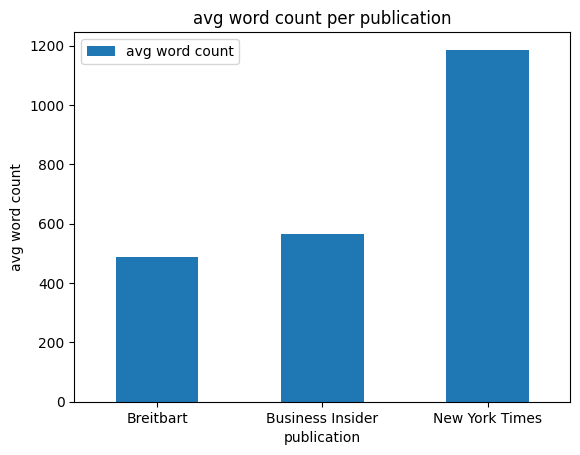

In [3]:
# simple graph of avg word count per publication
wc = article_df[['publication', 'content', 'date']]
wc['word_count'] = wc.apply(lambda x: len(str(x['content']).split(" ")), axis=1)
#print(wc.groupby(['publication'])['word_count'].mean().reset_index().rename(columns={'word_count':'avg word count'}))

wa = wc.groupby(['publication'])['word_count'].mean().reset_index().rename(columns={'word_count':'avg word count'})
ax = wa.plot.bar(x='publication', y='avg word count')
plt.ylabel('avg word count')
plt.title('avg word count per publication')
plt.xticks(rotation=0)

del wc, wa, ax

Text Pre-Processing

In [4]:
def text_clean(text):
    return re.sub('(\W+)', " ", text).lower() # replaces all non-word characters with a space and sets it to lower

# joining all text data (title, publication, author etc.) and removing all non-word chars
article_str_df = article_df[['title', 'publication', 'author', 'content']]
article_str_df['contentCL'] = article_str_df['title'].astype('str') + " "+ \
                              article_str_df['publication'].astype('str') + " "+\
                              article_str_df['author'].astype('str') +" "+ \
                              article_str_df['content'] # joining all text data in to one col
article_str_df['contentCL'] = article_str_df['contentCL'].progress_apply(text_clean)

article_str_df[:5][['content', 'contentCL', "publication"]]

100%|██████████| 9000/9000 [00:02<00:00, 3202.67it/s]


,content,contentCL,publication
0,WASHINGTON — Congressional Republicans have...,house republicans fret about winning their hea...,New York Times
1,"After the bullet shells get counted, the blood...",rift between officers and residents as killing...,New York Times
2,"When Walt Disney’s “Bambi” opened in 1942, cri...",tyrus wong bambi artist thwarted by racial bia...,New York Times
3,"Death may be the great equalizer, but it isn’t...",among deaths in 2016 a heavy toll in pop music...,New York Times
4,"SEOUL, South Korea — North Korea’s leader, ...",kim jong un says north korea is preparing to t...,New York Times


Text Processing for Bag Of Words
<font size = 3>
- Tokenization: The process of splitting text into a list of words.
<p> <font size=2>
ex:
"Trying is the first step toward failure." - Homer Simpson
["trying", "is", "the", "first", "step", "toward", "failure","."]
</font>
</p>
- Lemmatization: converting a word into a standardized form based off of the context, called a Lemma.
<p> <font size=2>
ex: Caring -> Care

</font>
</p>
</font>

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')
#nlp.Defaults.stop_words

#isolating the cleaned text column
texts = list(article_str_df['contentCL'].reset_index().drop(columns='index')['contentCL'])

del article_str_df, article_df

In [6]:
import itertools
import collections

def lemmatize_batch(docs):
    """
    using spacy lemma_ function to lemmatize the words in the docs and keep if not stop word
    Utalizing batching so we dont have to run nlp.pipe on the whole corpus. 
    :param docs: list of documents
    :return: list of lists of lemmatized and cleaned tokens for each document
    """
    # Batch documents together
    docs = list(docs)
    batch_size = 1000
    batches = [docs[i:i+batch_size] for i in range(0, len(docs), batch_size)]

    # Process batches using spacy parser
    lemmatized_docs = []
    for batch in tqdm(batches):
        docs = nlp.pipe(batch)
        lemmatized_batch = []
        for doc in docs:
            lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and len(str(token.lemma_)) > 3]
            lemmatized_batch.append(lemmatized_tokens)
        lemmatized_docs.extend(lemmatized_batch)

    return lemmatized_docs


In [7]:
#lemmatizing corpus (longest process of the whole thing works in O(M*N) for M docs and N words assuming the 
# lemmatization run time is o(1)
lemma_arr = lemmatize_batch(texts) 

###### REMOVE LATER
# lemma_arr = pd.read_csv('lemma_csv.csv').rename(columns={'0':'val'}).\
#     apply(lambda x: x['val'].split(" "), axis=1).tolist()
#######
word_list = list(itertools.chain(*lemma_arr)) #flattening the corpus using itertools.chain to get a list of all words in the corpus
N = len(word_list) # total number of words in the corpus
counted_words = collections.Counter(word_list) # count for each word 


100%|██████████| 9/9 [10:03<00:00, 67.07s/it] 


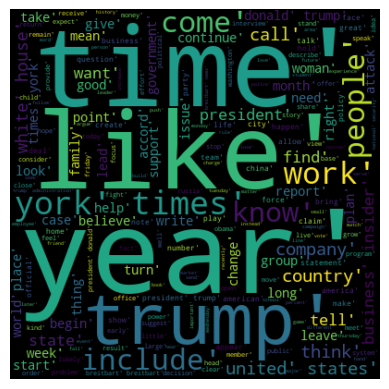

In [8]:
from wordcloud import WordCloud
wordcloud_words = [str(p) for p in lemma_arr]
wordcloud_strings = ",".join(wordcloud_words)
wordcloud_words = WordCloud(background_color='black', width=400, height=400).generate(wordcloud_strings)


plt.imshow(wordcloud_words, interpolation='bilinear')
plt.axis('off')
plt.show()
#counted_words.most_common(15)
del wordcloud_words, wordcloud_strings

#### N-GRAM Generation
----

<font size =2>

How do we calculate the probability of a ngram?

##### Markov Assumption
The idea that a future event can be predicted using the history of events

Markov assumption as it applies to us:
- we can estimate the probability of a phrase appearing from its relative frequency count.
to start we can calculate the probability of a word w given the some history h

$p(w|h)$ suppose that the history is "don't have a cow" we know that the probabily that the next word is man is
$p(man|dont\;have\; a \;cow)$

Compute:
$\frac{C(Dont\;have\;a\;cow\;man)}{C(Dont\;have\;a\;cow)}$
</font>


<font size = 1>
sources:

https://web.stanford.edu/~jurafsky/slp3/3.pdf
https://machinelearninginterview.com/topics/natural-language-processing/what-order-of-markov-assumption-is-done-for-n-grams/
</font>

In [9]:
# great ngram building method that is really quick
def find_ngrams(input_list, n): #http://www.locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
    return zip(*[input_list[i:] for i in range(n)])

#helper method to build a list of ngrams and return their frequencies
def ngram_freq(corpus, n):
    ngram_arr = [find_ngrams(doc, n) for doc in corpus]
    ngram_list = [tuple(doc) for doc in list(itertools.chain(*ngram_arr))]
    return collections.Counter(ngram_list)


In [10]:
ngram_freqs = [ngram_freq(lemma_arr, i) for i in tqdm(range(2,6))] #building a list of all ngrams bigrams to six-grams


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


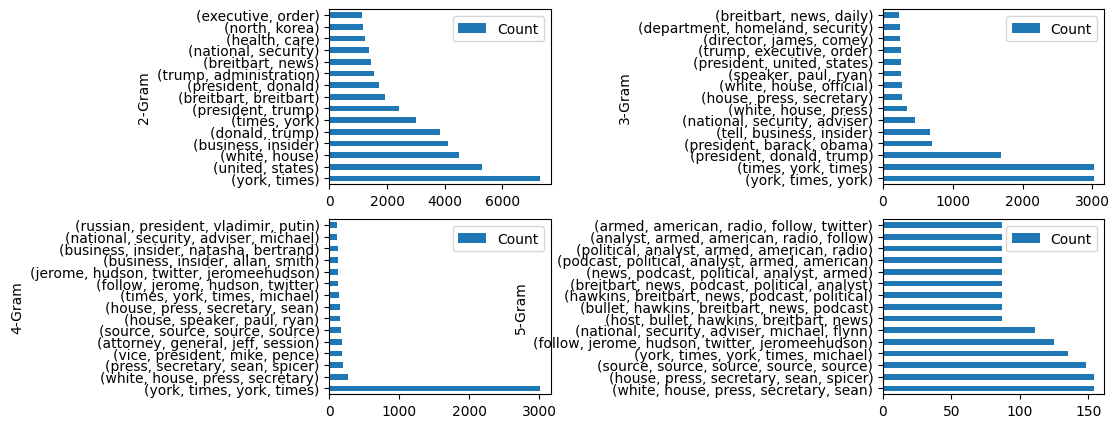

In [11]:
most_common = [ngram_freq(lemma_arr, i).most_common(15) for i in tqdm(range(2,6))]
df_ngrams = [pd.DataFrame(most_common[i], columns=[f"{str(i+2)}-Gram", 'Count']).set_index(f"{str(i+2)}-Gram") for i in range(len(most_common))]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

for i, df in enumerate(df_ngrams):
    row = i // 2
    col = i % 2
    df.plot(ax=axs[row, col], kind='barh')

fig.subplots_adjust(wspace=1.5)



In [12]:
def ngram_gen(corpus, n):
    '''
    helper method for running find_ngram on each doc could have definatly joined with ngram_freq() 
    but it runs quick enough it isn't that much more over head 
    '''
    return [list(find_ngrams(doc, n)) for doc in corpus]

def get_probability(key, count): 
    '''
    Get probability calculates the probability of an ngram given its count and the frequency of the 
    corresponding ngrams.
    1) checking if the key is a unigram and returning the probability of the unigram (word/number of tokens in the corpus)
    2) if the length of the key is greater than 1 denomenator found by looking up the count of the n-1 grams in the dict ngram_feqs 
       if the n-1 gram is a unigram look up the freq of the unigram 
    
    '''
    try:
        if len(key.split()) == 1: 
            return count/N
    except AttributeError:
        n_1 = key[:len(key)-1]
        if len(n_1) == 1:
            den = ngram_freqs[len(key)-2][key[:len(key)-1][0]]
        else:
            den = ngram_freqs[len(key)-2][key[:len(key)-1]]
        return count/den

ngram_freqs = [dict(freq) for freq in ngram_freqs]
ngram_freqs.insert(0, dict(counted_words)) #add back in unigrams

# at this point we have a list of dictionaries with ngrams and their counts
# with their position i in ngram_freqs corresponding to
# the ngram where n = i + 1 (0 = unigram, 1 = bigram, ...)

# building the dictionary of ngram probabilities
ngram_prob = {}
for dict_item in tqdm(ngram_freqs[1:]):
    for key in dict_item:
        if dict_item[key] != 1:
            ngram_prob[key] = get_probability(key, dict_item[key])

# exploring the ngrams
ngram_prob = pd.DataFrame.from_dict(ngram_prob, orient='index').reset_index().rename(columns={0:'prob'})
ngram_prob = ngram_prob[ngram_prob['prob'] != 1]
ngram_prob = ngram_prob[ngram_prob['prob'] > .03]
ngram_prob['count'] = ngram_prob.apply(lambda row: ngram_freqs[len(row['index'])-1][row['index']], axis=1)

# saved ngrams go back in to ngram_corpus in the same order as aboce (unigrams - 5 grams)
ngram_corpus = [ngram_gen(lemma_arr, i) for i in tqdm(range(2,6))]
ngram_corpus.insert(0, lemma_arr)

ngram_prob_set = set(ngram_prob['index']) #faster conditional testing
filtered_ngrams = [[[gram for gram in doc if gram in ngram_prob_set] for doc in ngram_corpus[i]] for i in tqdm(range(1, 5))]




100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [13]:
# joining ngrams back in to the docs and ready for the LDA model
ngram_strings = [[["_".join([i for i in gram]) for gram in doc] for doc in ngram_list] for ngram_list in tqdm(filtered_ngrams[1:])]
ngram_strings.insert(0, ngram_corpus[0])
joined_docs = [[" ".join([" ".join(i) for i in inner])]for inner in tqdm(zip(*ngram_strings))]
# joined_docs = [doc.split(' ') for doc in joined_docs]
joined_docs = [doc[0].strip().split(' ') for doc in joined_docs]

100%|██████████| 3/3 [00:00<00:00, 16.03it/s]
9000it [00:00, 63296.13it/s]


### Latent Dirichlet Allocation
<font size = 2>
The model only "sees" the words in the docs

The other parameters are inferred (Latent) one of these parameters is the topics

The LDA model views each doc as a combination of topics with a topic being assigned to each word.

Concept of an LDA

Assume three topics in the world: sports, fashion and food

each doc is made up of a percentage of topics

The LDA model will categorize each doc based off of the percentage of these topics

Then it will try to build its own topics based off of these rules

in reality, it works the other way around
it takes in the docs and tries to learn a model that best describes what makes up a topic.

<font size = 1>
sources:

https://www.youtube.com/watch?v=3mHy4OSyRf0&ab_channel=AndriusKnispelis
https://radimrehurek.com/gensim/models/ldamodel.html
</font>

In [14]:
import gensim.corpora as corpora
import pyLDAvis.gensim_models
from gensim.models import phrases, Phrases, ldamodel, CoherenceModel



def check_coherence_values(corpus, dictionary, texts, T):
    lda_model = ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=T,
                                                random_state=100, #random seed for reproducability
                                                update_every=1, # number of documents to be iterated through for each update
                                                alpha='asymmetric' # symmetric each topic is evenly distributed through out the corpus
                                                                   # asymmetric means distribution favors cetrian topics over others
                                )

    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=dictionary,
                                         coherence='u_mass')  # make not on my chose of u_mass instead of c_v https://palmetto.demos.dice-research.org/

    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    print('\nPerplexity:', lda_model.log_perplexity(corpus))

    return lda_model

def lda_model(docs, T):
    id2word_dict = corpora.Dictionary(docs)
    corpus = [id2word_dict.doc2bow(doc) for doc in docs]
    lda = check_coherence_values(corpus, id2word_dict, docs, T)
    pyLDAvis.enable_notebook()
    vis_ngram = pyLDAvis.gensim_models.prepare(lda, corpus, id2word_dict)
    return vis_ngram

In [21]:
lda_model(joined_docs,25)


Coherence Score:  -1.5169913726306379

Perplexity: -10.795817536125114


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.029186 -0.096490       1        1  13.042584
3     -0.082822 -0.030275       2        1   9.833326
10    -0.098918 -0.010927       3        1   8.146382
8      0.022060 -0.042874       4        1   7.360306
17     0.000137 -0.074895       5        1   6.630016
15    -0.142477  0.061059       6        1   6.426168
9     -0.107515  0.005436       7        1   5.943183
16    -0.017198 -0.041632       8        1   5.059208
13    -0.120739  0.008792       9        1   4.924853
21     0.021707 -0.064287      10        1   4.687154
5     -0.041031 -0.021486      11        1   3.916892
18     0.016958 -0.094467      12        1   3.683443
6     -0.077638  0.023111      13        1   3.562372
11    -0.027833  0.064211      14        1   2.968025
12     0.044048 -0.058788      15        1   2.695761
7      0.022151 -0.021768      16        1   2.151374
1      0.028013  0.046118      17        1   2.142963
4     -0.008057  0.051541      18        1   1.832338
22     0.099761 -0.033492      19        1   1.740940
2      0.103147 -0.015263      20        1   1.269144
20     0.020597  0.123391      21        1   0.902894
24     0.061119  0.043887      22        1   0.460629
0      0.065008  0.026667      23        1   0.333632
23     0.058991  0.060212      24        1   0.242892
19     0.131343  0.092216      25        1   0.043519, topic_info=            Term          Freq         Total Category  logprob  loglift
293        trump  31338.000000  31338.000000  Default  30.0000  30.0000
881    president  17414.000000  17414.000000  Default  29.0000  29.0000
1305     company   8283.000000   8283.000000  Default  28.0000  28.0000
16304  breitbart  21046.000000  21046.000000  Default  27.0000  27.0000
313         year  13908.000000  13908.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
307         want      1.388027   7744.470189  Topic25  -6.9077  -0.8871
39          case      1.271848   3792.453116  Topic25  -6.9952  -0.2606
1220    american      1.339906   6633.769800  Topic25  -6.9430  -0.7676
1153        week      1.300536   5346.764652  Topic25  -6.9729  -0.5817
1408        good      1.283973   6042.096705  Topic25  -6.9857  -0.7168

[2042 rows x 6 columns], token_table=       Topic      Freq                    Term
term                                          
16192      7  0.921639  2016_presidential_race
2          1  0.259007                    2017
2          2  0.099779                    2017
2          3  0.038401                    2017
2          4  0.071661                    2017
...      ...       ...                     ...
17762     17  0.002206              zuckerberg
17762     18  0.002206              zuckerberg
17762     20  0.002206              zuckerberg
17762     22  0.002206              zuckerberg
17762     25  0.004413              zuckerberg

[15642 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 4, 11, 9, 18, 16, 10, 17, 14, 22, 6, 19, 7, 12, 13, 8, 2, 5, 23, 3, 21, 25, 1, 24, 20])

In [16]:
def allow_postages(corpus, batch_size, allowed_postags=['NOUN', 'PROPN']): #'ADV', 'ADJ', 'PROPN','VERB'
    batches = [list(corpus[i:i+batch_size]) for i in range(0, len(corpus), batch_size)]
    noun_set = []
    for batch in tqdm(batches):
        docs = nlp.pipe(batch)
        noun_batch = []
        for doc in docs:
            noun_doc = [str(token) for token in doc if token.pos_ in allowed_postags or "_" in str(token)]
            noun_batch.append(noun_doc)
        noun_set.extend(noun_batch)
    return noun_set

In [17]:
noun_docs = allow_postages([" ".join(doc) for doc in joined_docs], 1000)

100%|██████████| 9/9 [04:55<00:00, 32.85s/it]


In [20]:
lda_model(noun_docs, 25)


Coherence Score:  -1.9447192920171306

Perplexity: -11.26169319472667


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.135553  0.117246       1        1  16.242488
11     0.117625  0.035140       2        1  12.027690
2      0.068268 -0.009070       3        1   9.227963
1      0.128671  0.052827       4        1   8.462993
4      0.061556 -0.103486       5        1   8.223268
7      0.109369 -0.005285       6        1   6.332716
15     0.026771  0.078745       7        1   4.346972
0      0.029056 -0.092998       8        1   4.062439
17     0.019252 -0.133146       9        1   3.988121
5      0.036800 -0.108667      10        1   3.884499
21     0.042557 -0.002479      11        1   3.743265
12     0.017626  0.001467      12        1   3.338173
18     0.021403  0.015202      13        1   3.027407
8      0.061733 -0.018668      14        1   2.883617
22    -0.025810  0.003010      15        1   2.145923
9     -0.017590  0.018775      16        1   1.363006
13    -0.104286  0.056418      17        1   1.321112
23    -0.006990  0.052391      18        1   1.215949
24    -0.089792 -0.038788      19        1   1.215872
19    -0.118243  0.090744      20        1   0.970337
14    -0.080598 -0.018772      21        1   0.687196
20    -0.043117  0.024195      22        1   0.520022
6     -0.047309 -0.000105      23        1   0.502980
16    -0.202724 -0.002908      24        1   0.133108
10    -0.139783 -0.011787      25        1   0.132883, topic_info=                 Term          Freq         Total Category  logprob  loglift
194             trump  30273.000000  30273.000000  Default  30.0000  30.0000
13514       breitbart  21417.000000  21417.000000  Default  29.0000  29.0000
624         president  18361.000000  18361.000000  Default  28.0000  28.0000
1472             news  10915.000000  10915.000000  Default  27.0000  27.0000
251            attack   5171.000000   5171.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
208             white      4.750353   5690.238774  Topic25  -6.4735  -0.4648
1139            state      5.017193  11962.253694  Topic25  -6.4189  -1.1532
2      administration      4.716434   5630.450649  Topic25  -6.4807  -0.4614
1876             plan      4.213429   4624.135080  Topic25  -6.5935  -0.3773
295          business      4.250839   7747.514616  Topic25  -6.5846  -0.8846

[1952 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
45203      9  0.501796       abedi
45203     18  0.228089       abedi
45203     24  0.228089       abedi
19664      1  0.951727      abedin
19664      4  0.009812      abedin
...      ...       ...         ...
14819     13  0.004172  zuckerberg
14819     14  0.771754  zuckerberg
14819     15  0.004172  zuckerberg
14819     17  0.008343  zuckerberg
14819     21  0.004172  zuckerberg

[14341 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 3, 2, 5, 8, 16, 1, 18, 6, 22, 13, 19, 9, 23, 10, 14, 24, 25, 20, 15, 21, 7, 17, 11])

/Users/maxlyman/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/maxlyman/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/maxlyman/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/maxlyman/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize 

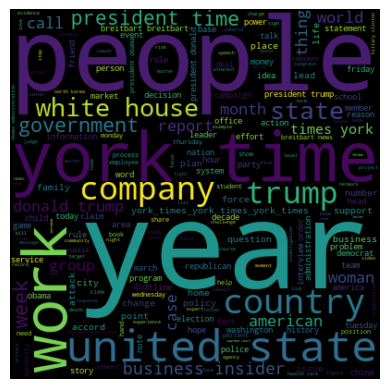

In [19]:

merged = " , ".join(list(itertools.chain(*noun_docs)))
merged = WordCloud(background_color='black', width=400, height=400).generate(merged)
plt.imshow(merged, interpolation='bilinear')
plt.axis('off')
plt.show()
#counted_words.most_common(15)
del merged